In [1]:
import time
from runze_valve import RunzeValve

In [10]:
cvalve = RunzeValve(com_port='COM9')
cvalve.set_current_port(3)
fvalve = RunzeValve(com_port='COM8')
fvalve.set_current_port(3)

Current port set to 3
Current port set to 3


In [2]:
from gdx import gdx
device = gdx.gdx()
device.open(connection='usb', device_to_open="GDX-DC 05501561")


In [3]:
device.select_sensors(1)

In [5]:
device.start(20)
column_headers= device.enabled_sensor_info()[0]
print(column_headers)
drops = 0
while drops < 20:  # collect 20 readings
        measurements = device.read()
        if measurements == None: 
                drops += 0 
                print("Drop interval > 5s")
                continue
        drops += 1
        print(drops)
        time.sleep(0.1)
device.stop()

Drop Counter (Drops)
1


KeyboardInterrupt: 

In [1]:
import serial
import time
import threading
import pandas as pd

# === CONFIGURATION ===
COM_PORT = 'COM15'          # Your FX-120i serial port
BAUD_RATE = 19200
DURATION_SEC = 5 * 60       # Run for 5 minutes

# === SHARED LOGS AND LOCK ===
data_log = []               # List of tuples: (timestamp, weight, scale_drop, vernier_drop)
log_lock = threading.Lock()
running = True              # Global flag to stop threads

# === VERNER DROP COUNTER THREAD ===
def vernier_drop_counter(device):
    device.start(20)
    column_headers = device.enabled_sensor_info()[0]
    print(f"Vernier sensor columns: {column_headers}")

    drops = 0
    try:
        while running:
            measurements = device.read()
            if measurements == None: 
                    drops += 0 
                    print("Drop interval > 5s")
                    continue
            drops += 1
            print(f"Vernier: Drops counted: {drops}")
            with log_lock:
                data_log.append((time.time(), None, None, drops))
            time.sleep(0.02)
    except KeyboardInterrupt:
        print("Vernier drop counter stopped by user.")
    finally:
        device.stop()
        print("Vernier device stopped.")

# === FX-120i SERIAL SCALE READER THREAD ===
def scale_reader():
    global running
    try:
        ser = serial.Serial(
            port=COM_PORT,
            baudrate=BAUD_RATE,
            bytesize=serial.EIGHTBITS,
            parity=serial.PARITY_NONE,
            stopbits=serial.STOPBITS_ONE,
            timeout=1
        )
        print(f"Scale connected on {COM_PORT} at {BAUD_RATE} baud.")

        start_time = time.time()
        while running and (time.time() - start_time) < DURATION_SEC:
            timestamp = time.time()
            weight = None
            drop_flag = 0

            try:
                ser.write(b'Q\r\n')
                time.sleep(0.2)
                raw = ser.readline().decode(errors='ignore').strip()

                if raw.startswith("ST,") or raw.startswith("US,"):
                    try:
                        weight_str = raw.split(',')[1].strip().split()[0]
                        weight = float(weight_str)
                        print(f"Scale: {time.strftime('%H:%M:%S')} | Weight: {weight:.4f} g")
                    except:
                        drop_flag = 1
                        print(f"Scale drop: parse error")
                else:
                    drop_flag = 1
                    print(f"Scale drop: invalid/no response '{raw}'")

            except Exception as e:
                drop_flag = 1
                print(f"Scale error: {e}")

            # Log scale reading and drop, vernier_drop = None here
            with log_lock:
                data_log.append((timestamp, weight, drop_flag, None))

            time.sleep(0.2)

    finally:
        if 'ser' in locals() and ser.is_open:
            ser.close()
        running = False
        print("Scale serial port closed.")

# === MAIN PROGRAM ===
def main(device):
    global running

    # Start Vernier thread
    vernier_thread = threading.Thread(target=vernier_drop_counter, args=(device,), daemon=True)
    vernier_thread.start()

    # Start Scale reader in main thread (or use a thread if you prefer)
    try:
        scale_reader()
    except KeyboardInterrupt:
        print("Main stopped by user.")
    finally:
        running = False
        vernier_thread.join()

        # Process and print log summary
        if data_log:
            with log_lock:
                df = pd.DataFrame(data_log, columns=["timestamp", "weight", "scale_drop", "vernier_drop"])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

            print("\nData sample:")
            print(df.tail())

            # Drop summary per minute (scale drops)
            scale_drops_summary = df[df['scale_drop'].notna()].groupby(df['timestamp'].dt.floor('min'))['scale_drop'].sum()
            print("\nScale drops per minute:")
            print(scale_drops_summary)

            # Drop summary per minute (vernier drops)
            vernier_drops_summary = df[df['vernier_drop'].notna()].groupby(df['timestamp'].dt.floor('min'))['vernier_drop'].sum()
            print("\nVernier drops per minute:")
            print(vernier_drops_summary)
        else:
            print("No data logged.")

# === USAGE ===
if __name__ == "__main__":
    # Initialize your Vernier device here:
    # from your_vernier_lib import DeviceClass
    # device = DeviceClass(...)
    
    # Example dummy placeholder (replace with your actual device init)
    from gdx import gdx
    device = gdx.gdx()
    device.open(connection='usb', device_to_open="GDX-DC 05501561")
    device.select_sensors(1)

    main(device)


Vernier sensor columns: Drop Counter (Drops)
Scale connected on COM15 at 19200 baud.
Scale: 18:22:20 | Weight: 0.0000 g
Scale: 18:22:20 | Weight: 0.0000 g
Scale: 18:22:21 | Weight: 0.0000 g
Scale: 18:22:21 | Weight: 0.0000 g
Scale: 18:22:21 | Weight: 0.0000 g
Scale: 18:22:22 | Weight: 0.0010 g
Scale: 18:22:22 | Weight: 0.0000 g
Scale: 18:22:23 | Weight: 0.0000 g
Scale: 18:22:23 | Weight: 0.0000 g
Scale: 18:22:24 | Weight: 0.0000 g
Scale: 18:22:24 | Weight: 0.0000 g
Scale: 18:22:24 | Weight: 0.0000 g
ERROR: HID read timeout!
Drop interval > 5s
Scale: 18:22:25 | Weight: -0.0010 g
Scale: 18:22:25 | Weight: 0.0000 g
Scale: 18:22:26 | Weight: 0.0000 g
Scale: 18:22:26 | Weight: 0.0000 g
Scale: 18:22:26 | Weight: 0.0000 g
Scale: 18:22:27 | Weight: 0.0000 g
Scale: 18:22:27 | Weight: 0.0000 g
Scale: 18:22:28 | Weight: 0.0000 g
Scale: 18:22:28 | Weight: 0.0000 g
Scale: 18:22:28 | Weight: 0.0000 g
Scale: 18:22:29 | Weight: 0.0000 g
Scale: 18:22:29 | Weight: 0.0010 g
Scale: 18:22:30 | Weight: 0.00

In [5]:
df = pd.DataFrame(data_log, columns=["timestamp", "weight", "scale_drop", "vernier_drop"])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


C:\Users\SDL4\AppData\Local\Temp\ipykernel_20080\734564002.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ax2.plot(df['timestamp'], df['vernier_drop'].fillna(method='ffill').fillna(0), 'r-', label='Vernier Drops (cumulative)')


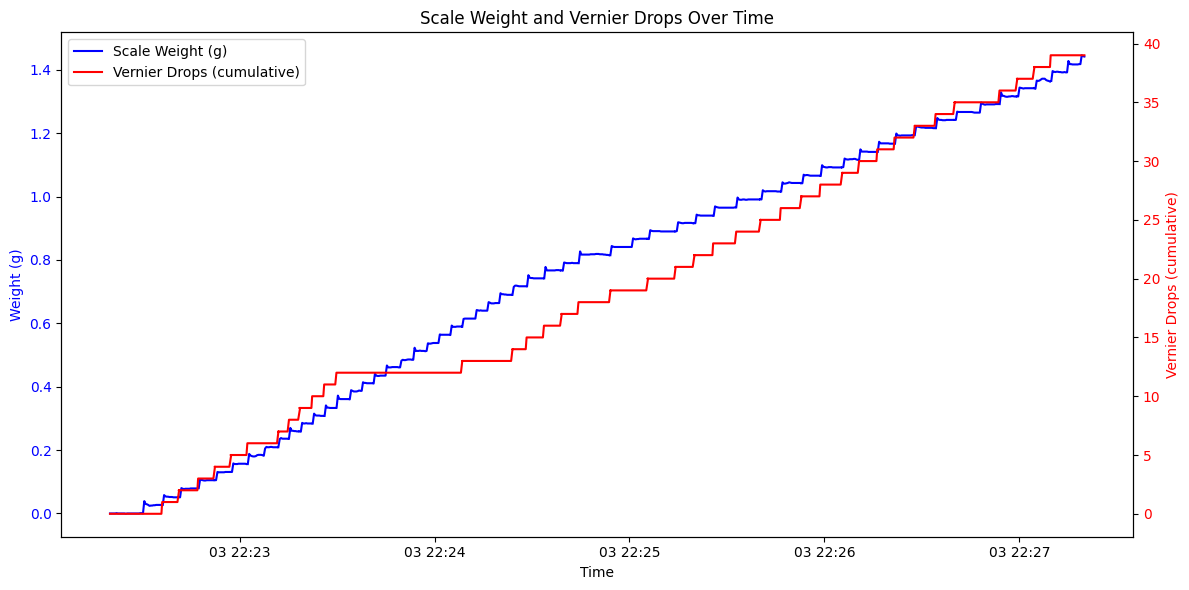

In [6]:
import matplotlib.pyplot as plt

# After creating df and converting timestamp...

# Plot Vernier drops and Scale weight over time
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot scale weight on primary y-axis
ax1.plot(df['timestamp'], df['weight'], 'b-', label='Scale Weight (g)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Weight (g)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create secondary y-axis for Vernier drop count
ax2 = ax1.twinx()

# Vernier drop is cumulative count, plot it as line
ax2.plot(df['timestamp'], df['vernier_drop'].fillna(method='ffill').fillna(0), 'r-', label='Vernier Drops (cumulative)')
ax2.set_ylabel('Vernier Drops (cumulative)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Optional: Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Scale Weight and Vernier Drops Over Time')
plt.tight_layout()
plt.show()
